<a href="https://colab.research.google.com/github/monkrus/legal_llm/blob/main/finetune_pretrained_llm2_flowchart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach to fine tune pretrained modelwith added flowchart.
Med-high accuracy (0.75)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.671811,0.750000,0.562500,0.750000,0.642857
2,No log,0.671867,0.750000,0.562500,0.750000,0.642857
3,No log,0.671913,0.750000,0.562500,0.750000,0.642857
4,No log,0.672093,0.750000,0.562500,0.750000,0.642857
5,0.704200,0.672508,0.750000,0.562500,0.750000,0.642857
6,0.704200,0.673183,0.750000,0.562500,0.750000,0.642857
7,0.704200,0.674102,0.750000,0.562500,0.750000,0.642857
8,0.704200,0.674821,0.750000,0.562500,0.750000,0.642857
9,0.704200,0.676182,0.750000,0.562500,0.750000,0.642857
10,0.692200,0.677350,0.750000,0.562500,0.750000,0.642857


Validation Loss: 0.6718109250068665
Validation Accuracy: 0.75
Validation Precision: 0.5625
Validation Recall: 0.75
Validation F1 Score: 0.6428571428571428


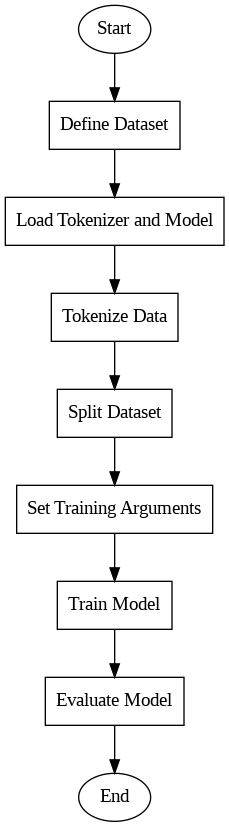

In [10]:
# Ensure required packages are installed
!apt-get install graphviz -y
!pip install torch==2.3.1+cu121 transformers datasets numpy graphviz pydot pyarrow==15.0.0 fsspec==2024.5.0 requests==2.32.2



# Import necessary libraries
import pydot
from IPython.display import Image
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
from sklearn.metrics import classification_report

# Define dataset
texts = [
    "Party A alleges a breach of contract due to non-delivery of goods.",
    "Party B is accused of fraud for misrepresenting financial information.",
    "Company C filed a lawsuit for intellectual property theft.",
    "Person D claims defamation in the recent publication.",
    "Party E is accused of breach of contract for late delivery.",
    "Person F alleges discrimination in the workplace.",
    "Company G sues for trademark infringement.",
    "Person H accuses the landlord of unlawful eviction.",
    "Party I is involved in a case of patent violation.",
    "Company J is accused of false advertising.",
    "Party K claims breach of warranty for defective products.",
    "Person L files a case for personal injury due to negligence.",
    "Company M is involved in a dispute over unpaid royalties.",
    "Party N alleges insider trading by corporate executives.",
    "Person O sues for emotional distress due to harassment.",
    "Organization P files a class-action lawsuit for data breach.",
    "Party Q accuses the company of wrongful termination.",
    "Person R claims copyright infringement for their creative work.",
    "Company S sues for breach of non-compete agreement.",
    "Party T is involved in a case of product liability.",
]

labels = [
    0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
    0, 1, 0, 1, 1, 0, 1, 0, 1, 0
]

# Ensure labels match the number of texts
assert len(texts) == len(labels), "Number of texts and labels must match."

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert texts to dataset
dataset = Dataset.from_dict({
    'text': texts,
    'label': labels
})

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove columns not needed for training
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

# Split the dataset into training and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Increase number of epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Ensure this matches with save_strategy
    save_strategy="epoch",        # Save the model at each epoch
    learning_rate=5e-5,           # Adjust learning rate
    save_total_limit=3,           # Limit the number of saved checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
)

# Load the accuracy metric with trust_remote_code=True
accuracy_metric = load_metric("accuracy", trust_remote_code=True)

from sklearn.metrics import classification_report

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']

    # Calculate classification report
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)

    # Extract scalar metrics
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
eval_result = trainer.evaluate()

print(f"Validation Loss: {eval_result['eval_loss']}")
print(f"Validation Accuracy: {eval_result['eval_accuracy']}")
print(f"Validation Precision: {eval_result['eval_precision']}")
print(f"Validation Recall: {eval_result['eval_recall']}")
print(f"Validation F1 Score: {eval_result['eval_f1']}")

# Create flowchart using pydot
graph = pydot.Dot(graph_type="digraph")

# Nodes
graph.add_node(pydot.Node("Start", shape="ellipse"))
graph.add_node(pydot.Node("Define Dataset", shape="box"))
graph.add_node(pydot.Node("Load Tokenizer and Model", shape="box"))
graph.add_node(pydot.Node("Tokenize Data", shape="box"))
graph.add_node(pydot.Node("Split Dataset", shape="box"))
graph.add_node(pydot.Node("Set Training Arguments", shape="box"))
graph.add_node(pydot.Node("Train Model", shape="box"))
graph.add_node(pydot.Node("Evaluate Model", shape="box"))
graph.add_node(pydot.Node("End", shape="ellipse"))

# Edges
graph.add_edge(pydot.Edge("Start", "Define Dataset"))
graph.add_edge(pydot.Edge("Define Dataset", "Load Tokenizer and Model"))
graph.add_edge(pydot.Edge("Load Tokenizer and Model", "Tokenize Data"))
graph.add_edge(pydot.Edge("Tokenize Data", "Split Dataset"))
graph.add_edge(pydot.Edge("Split Dataset", "Set Training Arguments"))
graph.add_edge(pydot.Edge("Set Training Arguments", "Train Model"))
graph.add_edge(pydot.Edge("Train Model", "Evaluate Model"))
graph.add_edge(pydot.Edge("Evaluate Model", "End"))

# Save and display the graph
graph.write_png("flowchart.png")
Image(filename="flowchart.png")
